The goal of this notebook is to generalize the `aftereburner` function that is needed to run the denoising algorithm over patches of the full FVC image and then stitches these denoised patches together to create the fully denoised FVC image.

The high level idea behind the afterburner function is to denoise patches



~(2000x2000) image patches of the larger (6000,6000) FVC image. The reason I put ~(2000x2000) is because the previous iteration of the afterburner function didn't attenuate the artifacts that are caused by non-overlapping inference patches. The actual size of the patches will be (2020x2020), so that can run inference over the entire patch and throw away the border without having any problems with 

# `afterburner` using PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN_2k, DnCNN_B, DnCNN
from PT_files.Dataset import Img_Dataset
# from PT_files.afterburner_torch import afterburner, grid_window
from PT_files.new_afterburner_torch import full_pass_torch, grid_window
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os


device = "cuda" if torch.cuda.is_available() else "cpu"

Using cpu device


In [2]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name), map_location='cpu') # Used on CPU only machine


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3000, 1000:3000]
sub_samp = samp.reshape((1, 1, 2000, 2000))
sample = sample[0][0]
sample = sample.reshape((1, 1, 6000, 6000))
# samp = sample[0][0]

Shape of test set= (108, 1, 6000, 6000)


### Plotting Function

In [14]:
def afterburner_int_plot(raw_data,
                       inf_data,
                       size,
                       x_start_idx,
                       y_start_idx):
    
   
    denoised = inf_data[0][0]#[y_start_idx:y_start_idx+size, x_start_idx:x_start_idx+size]
    
    fig, ax = plt.subplots(2, 2,figsize=(26, 22))
    
    # For full image
    vmin, vmax = np.percentile(raw_data[0][0][0], (1,99))
    # For residuals
    vmax_resid = np.percentile(np.abs((raw_data[1][0][0] - raw_data[0][0][0])), (90))
    vmin_resid = -vmax_resid
    
    # Visualizing the discontinuity in the denoised images
    rect1 = Rectangle((1900, 2100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect2 = Rectangle((3900, 2100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect3 = Rectangle((1900, 4100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')
    rect4 = Rectangle((3900, 4100), 200, 200, linewidth=4, edgecolor='r', facecolor='none')

    # Comparing truth vs. noise 
    ax[0,0].imshow(denoised[1900:2100, 1900:2100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,0].axis('off')
    ax[0,0].set_title('TL 4-way intersection',fontsize=28) 
    ax[0,0].add_patch(rect1)
    ax[0,1].imshow(denoised[1900:2100, 3900:4100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0,1].axis('off')
    ax[0,1].set_title('TR 4-way intersection',fontsize=28)
    ax[0,1].add_patch(rect2)

  
    ax[1,0].imshow(denoised[3900:4100, 1900:2100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,0].axis('off')
    ax[1,0].set_title('BL 4-way intersction', fontsize=28)
    ax[1,0].add_patch(rect3)
    ax[1,1].imshow(denoised[3900:4100, 3900:4100], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1,1].axis('off')
    ax[1,1].set_title('BR 4-way intersction', fontsize=28)
    ax[1,1].add_patch(rect4)
    
       
    fig.tight_layout()
    plt.show()
    
# afterburner_int_plot(raw_data=test_data, 
#                  inf_data=full,
#                  size=200,
#                  x_start_idx=0,
#                  y_start_idx=0)

# Working on PyTorch Afterburner

Good little guide on padding images in Python using [Numpy](https://www.pythoninformer.com/python-libraries/numpy/image-operations/).

Numpy `pad` function:
    `padded_array = np.pad(array, ((50, 150), (80, 20), (0, 0)))`
The padding is specified by the sequence:
    `((50, 150), (80, 20), (0, 0))`
This is a tuple of 3 tuples:
- `(50, 150)` specifies that the first axis (the image rows) should be padded by `50` at the start, `150` at the end. This adds a `50` pixel margin at the top of the image and a `150` pixel margin at the bottom of the image.
- `(80, 20)` specifies that the second axis (the image columns) should be padded by the `80` at the start, `20` at the end. This adds an `80` pixel margin at the left of the image and a `20` pixel margin at the right of the image.
- `(0, 0)` specifies that no padding should be used on the third axis. Thee third axis, as we know, has a length of 3 and represents the RGB. values for each pixel. We don't want to pad that axis because we don't want to change the colours of the pixels in any way.

**For the FVC images (`FVC.shape = (N,C,H,W)`) it looks like:**
    `padded_array = np.pad(FVC_img, ((0,0), (0,0), (2000,2000), (2000,2000)))`
- `(0,0)` because the first axis in our image arrays is the sample axis, and we don't want to change anything here
- `(0,0)` because the second axis in our image arrays is the channel axis, and we don't want to change the values of our channels (even though they're grayscale, so not much could be done here anyway).
- `(20,20)` specifies the third axis (image rows) should be padded by `20` at the start and end. This adds a `20` pixel margin at top and bottom of the image.
- `(20,20)` specifies the fourth axis (image columns) should be added by `20` at the start and end. This adds a `20` pixel margin at the left and right of the image.


this is the sample axis, and we dont want to mess with anything here
- 

In [3]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end,
                padding):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    # Create 2 arrays of same size. full takes the denoised pixel values
    # and count keeps track of how many times an individual pixel has
    # inference ran on it
    # full = np.empty((1, 1, 6000, 6000))
    # count = np.empty((1, 1, 6000, 6000))
    
    # Get the noisy image data 
    # noise_data = dataset[0] # UNCOMMENT if using not w/in other func
    noise_data = dataset # UNCOMMENT if using grid_window w/in other func
    noise_data = np.pad(noise_data, ((0,0), (0, 0), (padding, padding), (padding, padding)))
    params_name = model_params
    
    # Get the correct patht to the moodel weights
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    
    # Instantiate the model, put it onto the GPU, load the weights
    # of the trained model, and then set the model into evaluation mode
    # for inference.
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()

    # Turn off gradient tracking so as to not update
    # the model weights
    with torch.no_grad():
                
        # Delete any remaining memory, turn the sub_image patch numpy array
        # into a torch tensor, so as to be compatible with the model, and
        # then put the data onto the GPU so as to be in the same place as 
        # the model.
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)

        # Run the model on the noisy images, then detach the output from
        # the GPU and put it onto CPU while making it into a numpy array.
        # Delete 'output' so as to save memory
        output = model(test_noise)
        resid_img = output.detach().cpu().numpy()
        del output
        
        # Same as above more or less
        test_noise.detach().cpu()
        torch.cuda.empty_cache()
        del test_noise
        
        # Deleting things to save memory.
        torch.cuda.empty_cache()
        
    return resid_img


Need the patches to overlap, but **need** to cut the overlapping regions so that there are only one unique denoised pixel per patch, so when stitching is done theres no weird discontinuities like we're seeing here.

Just trying to see if the artifact shows up if we increase the padding and then dropping the overlapping region. What David showed me during out meeting.

In [5]:
# # These three are the top row. That means they all have the same height
# # which from my calculations should be length of 1995 and from [15:2010]

# patch1 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=0,
#                     h_end=2020,
#                     w_start=0,
#                     w_end=2020,
#                     padding=10)
# # Top LHS
# print(patch1.shape)

# patch2 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=0,
#                     h_end=2020,
#                     w_start=2000,
#                     w_end=4020,
#                     padding=10)
# # top center
# print(patch2.shape)

# patch3 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=0,
#                     h_end=2020,
#                     w_start=4000,
#                     w_end=6020,
#                     padding=10)
# # top RHS
# print(patch3.shape)

# patch4 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=2000,
#                     h_end=4020,
#                     w_start=0,
#                     w_end=2020,
#                     padding=10)
# # center LHS
# print(patch4.shape)

# patch5 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=2000,
#                     h_end=4020,
#                     w_start=2000,
#                     w_end=4020,
#                     padding=10)
# # center center
# print(patch5.shape)

# patch6 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=2000,
#                     h_end=4020,
#                     w_start=4000,
#                     w_end=6020,
#                     padding=10)
# # middle RHS
# print(patch6.shape)

# patch7 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=4000,
#                     h_end=6020,
#                     w_start=0,
#                     w_end=2020,
#                     padding=10)
# # bottom LHS
# print(patch7.shape)

# patch8 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=4000,
#                     h_end=6020,
#                     w_start=2000,
#                     w_end=4020,
#                     padding=10)
# # bottom center
# print(patch8.shape)

# patch9 = grid_window(dataset=test_data,
#                     model=DnCNN_B,
#                     model_params='2k_model_bs64_e800_ps50_Adam.pth',
#                     samp_idx=0,
#                     h_start=4000,
#                     h_end=6020,
#                     w_start=4000,
#                     w_end=6020,
#                     padding=10)
# # bottom RHS
# print(patch9.shape)

# full = np.zeros((1, 1, 6000, 6000))
# full[:, :, 0:2000, 0:2000] += patch1[:, :, 10:-10, 10:-10]
# full[:, :, 0:2000, 2000:4000] += patch2[:, :, 10:-10, 10:-10]
# full[:, :, 0:2000, 4000:6000] += patch3[:, :, 10:-10, 10:-10]
# full[:, :, 2000:4000, 0:2000] += patch4[:, :, 10:-10, 10:-10]
# full[:, :, 2000:4000, 2000:4000] += patch5[:, :, 10:-10, 10:-10]
# full[:, :, 2000:4000, 4000:6000] += patch6[:, :, 10:-10, 10:-10]
# full[:, :, 4000:6000, 0:2000] += patch7[:, :, 10:-10, 10:-10]
# full[:, :, 4000:6000, 2000:4000] += patch8[:, :, 10:-10, 10:-10]
# full[:, :, 4000:6000, 4000:6000] += patch9[:, :, 10:-10, 10:-10]
# plt.imshow(full[0][0])

In [6]:
# # NO ARTIFACT FOUND!!!!

# plt.imshow(full[0][0][5500:5700, 3900:4100])

In [7]:
# afterburner_int_plot(test_data, full, 200, 0, 0)

In [8]:
# data = test_data[0][0][0]
# data = np.reshape(data, (1, 1, 6000, 6000))
# inf_patch_size = 2000
# inf_patch_length = int(len(data[0][0]) / inf_patch_size)
# # print(inf_patch_length)

# # We then create the indices of where one inference patch ends and
# # the other one begins and save those tuples together in a list for
# # use later.
# window_end_idx = []
# for k in range(inf_patch_length):
#     window_end_idx.append(inf_patch_size*(k))
# # print(window_end_idx)
# window_end_idx.append(len(data[0][0])) # appends endpt ie. 6k
# # print(window_end_idx)

# # print(window_end_idx)
# # Full image pass
# # Instantiate 2 arrays of 6000x6000 for saving the denoised inference
# # patches in the correct location within the full 6k by 6k image, as 
# # well as counting which pixels have inference ran on them.
# full = np.empty((1, 1, 6000, 6000))
# count = np.empty((1, 1, 6000, 6000))

# # Loop through the patch indices, so as to create a loop that runs 
# # inference on non-overlapping regions of the full 6000x6000 image.
# # For a 2k by 2k patch we'd run this the model 9 times to cover the
# # FVC image.
# for j in range(len(window_end_idx)-1):
#     for i in range(len(window_end_idx)-1):
#         print(window_end_idx[i])
        
        

In [9]:
def full_pass_torch(data, model, model_params, patch_size=2000, padding=10):
    """
    Function that uses a sliding window to run inference over the full FVC
    image. There is some overlap (~10 pixels) depending on the location of
    the patch.
    
    
    Parameters:
    -----------
    data: np.array
        Array of the noisy FVC exposure.
    model: DnCNN_B
        The denoising CNN model to be used.
    model_params: OrderedDict
        Pickled OrderedDict of the trained model weights.
    patch_size: int
        Size of the inference window.
        Defaults to 2000.
    padding: int
        How much to pad the input image to allow for artifact free 
        stitching of denoised patchs.
        Defaults to 10.
    """
    
    # Reshape the image to be in the correct format to be used in model.
    noisy = np.reshape(data, (1, 1, 6000, 6000))
    # Pad the full image at the end of the width and height of the image.
    # Meaning there will be an extra 10 pixels to the RHS and bottom of the
    # image resulting in FVC_img.shape = (1, 1, 6010, 6010)
    noisy = np.pad(noisy, ((0,0), (0,0), (padding,padding), (padding,padding)))
    
    # Get how many patchs fit within our FVC image.
    # E.g. patchs_per_dim == 3 if patch_size == 2000
    patchs_per_dim = int(len(data) / patch_size)
    
    # Create the indices of where one patch ends and the other one begins.
    # Save those together in a list for later use. Expected output will
    # be [0, 2000, 4000, 6000] if using patch_size=2000.
    window_end_idx = []
    for k in range(patchs_per_dim):
        window_end_idx.append(patch_size*(k))
    window_end_idx.append(len(data)) # appends endpt. ie. 6k
    
    # Instantiate an array of 6000x6000 for saving the denoised inference
    # patches in the correct location within the full 6k by 6k image.
    full = np.zeros((1, 1, 6000, 6000))
    
    # Loop through the patch indices to create a loop that runs inference
    # on regions of the full 6000x6000 image. For a 2k by 2k patch we'd run
    # this 9 times to cover the entire FVC image.
    for j in range(len(window_end_idx)-1):
        for i in range(len(window_end_idx)-1):
            
            denoised_patch = grid_window(dataset=noisy,
                                        model=model,
                                        model_params=str(model_params),
                                        samp_idx=0,
                                        h_start=window_end_idx[i],
                                        h_end=window_end_idx[i+1]+(padding*2),
                                        w_start=window_end_idx[j],
                                        w_end=window_end_idx[j+1]+(padding*2),
                                        padding=padding)
            
            denoised_patch = denoised_patch[:, :, 10:-10, 10:-10]
            
            full[:, :, window_end_idx[i]:window_end_idx[i+1],
                 window_end_idx[j]:window_end_idx[j+1]] += denoised_patch


    return full

In [10]:
test_data[0][0][0].shape

(6000, 6000)

In [11]:
denoised = full_pass_torch(data=test_data[0][0][0],
                           model=DnCNN_B,
                           model_params='2k_model_bs64_e800_ps50_Adam.pth')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

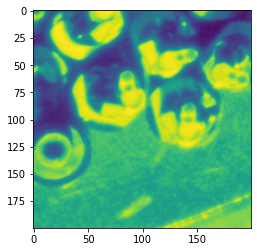

In [39]:
plt.imshow(test_data[0][0][0][5500:5700, 3900:4100])

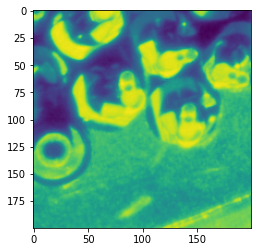

In [40]:
plt.imshow(denoised[0][0][5510:5710, 3910:4110])

**Making progress!** There is no longer any artifact, **BUT** theree is an offset between the denoised and the original. Need to fix this before being useful.

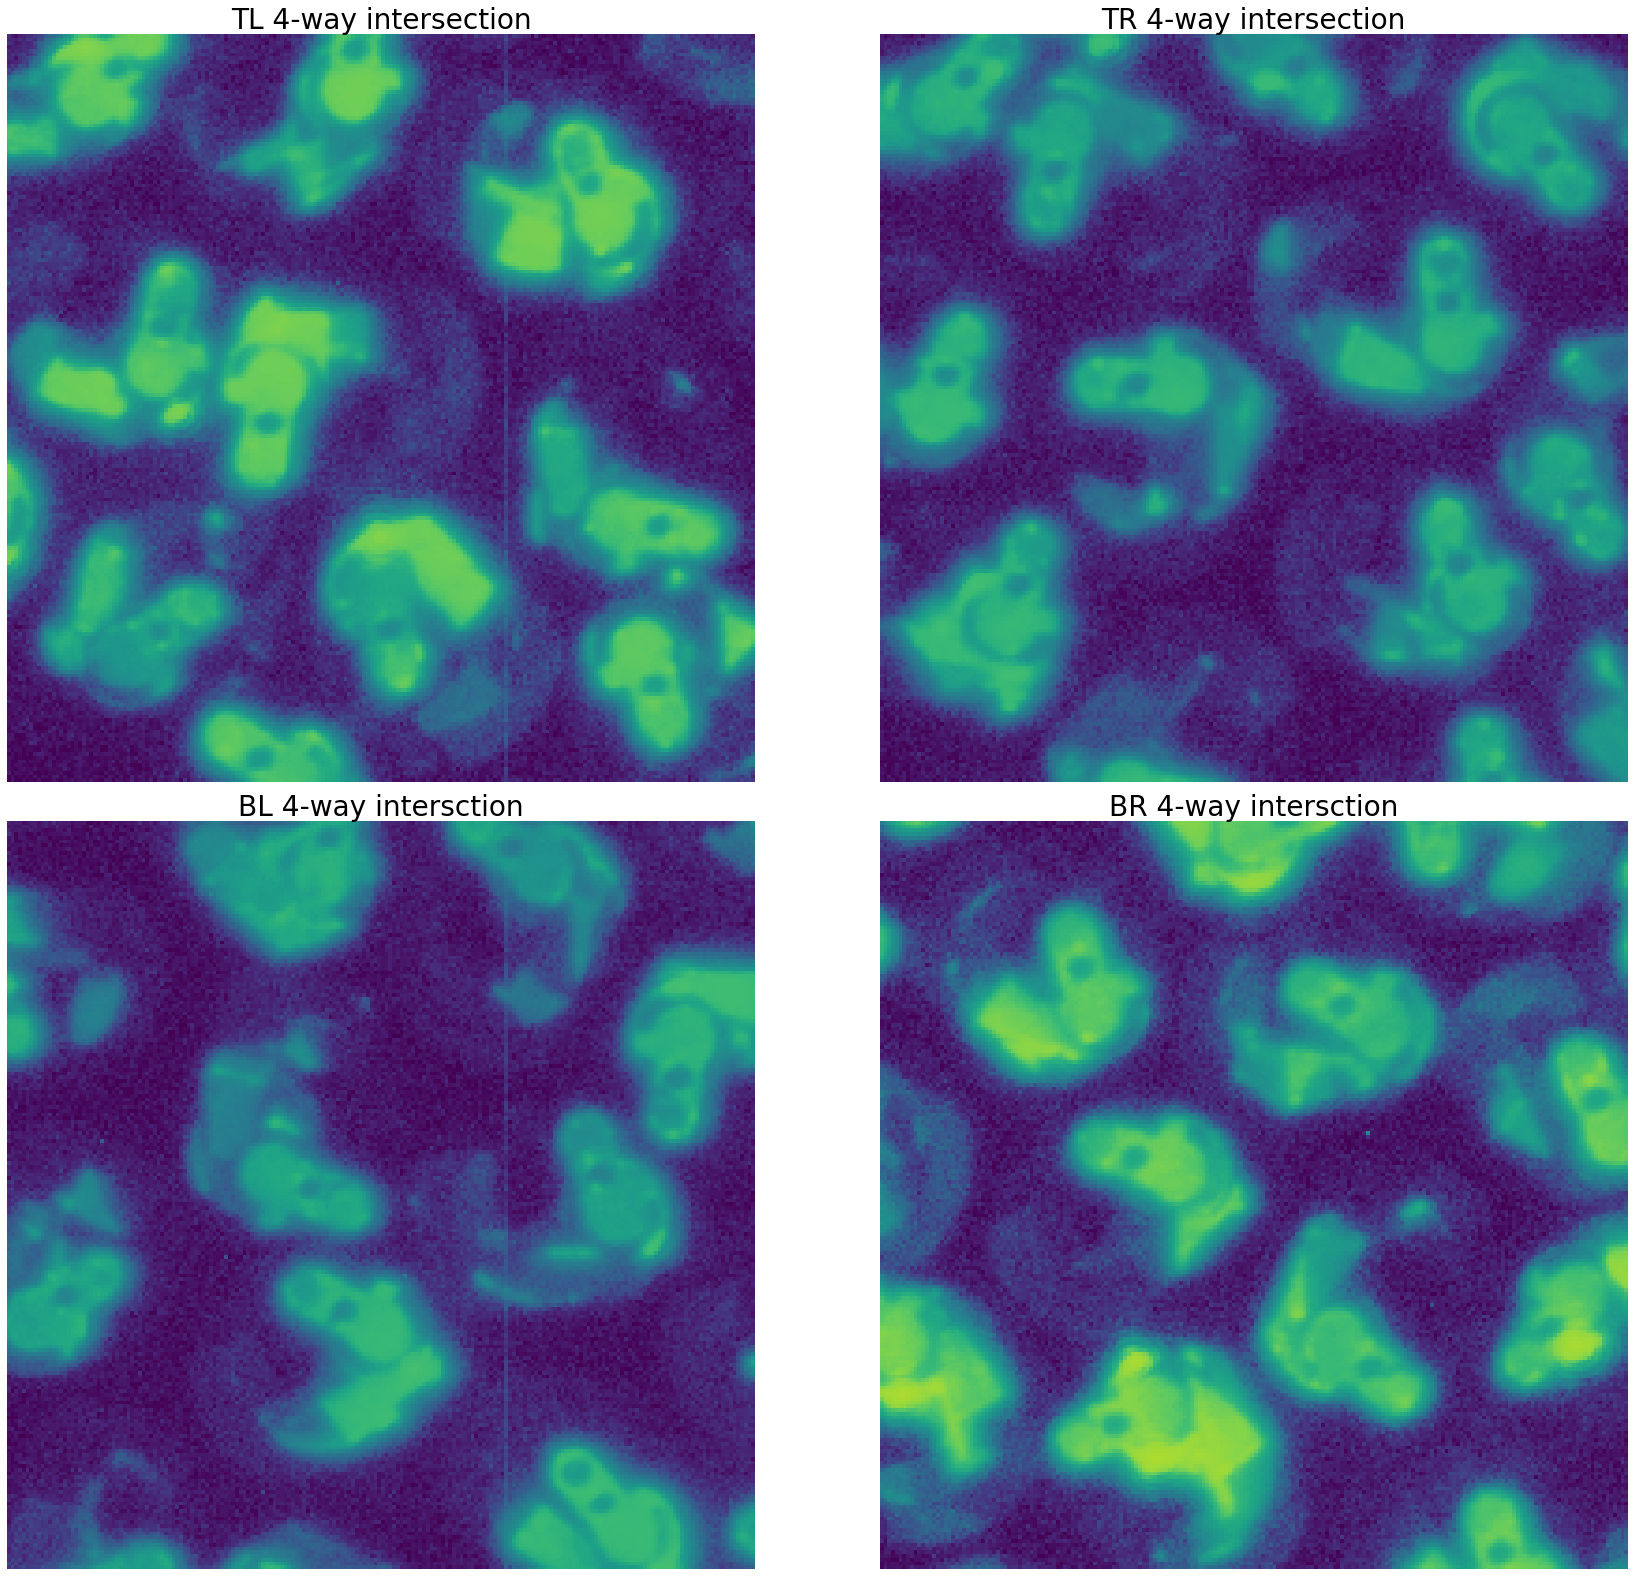

In [24]:
afterburner_int_plot(test_data, test_data[0], 200, 0, 0)

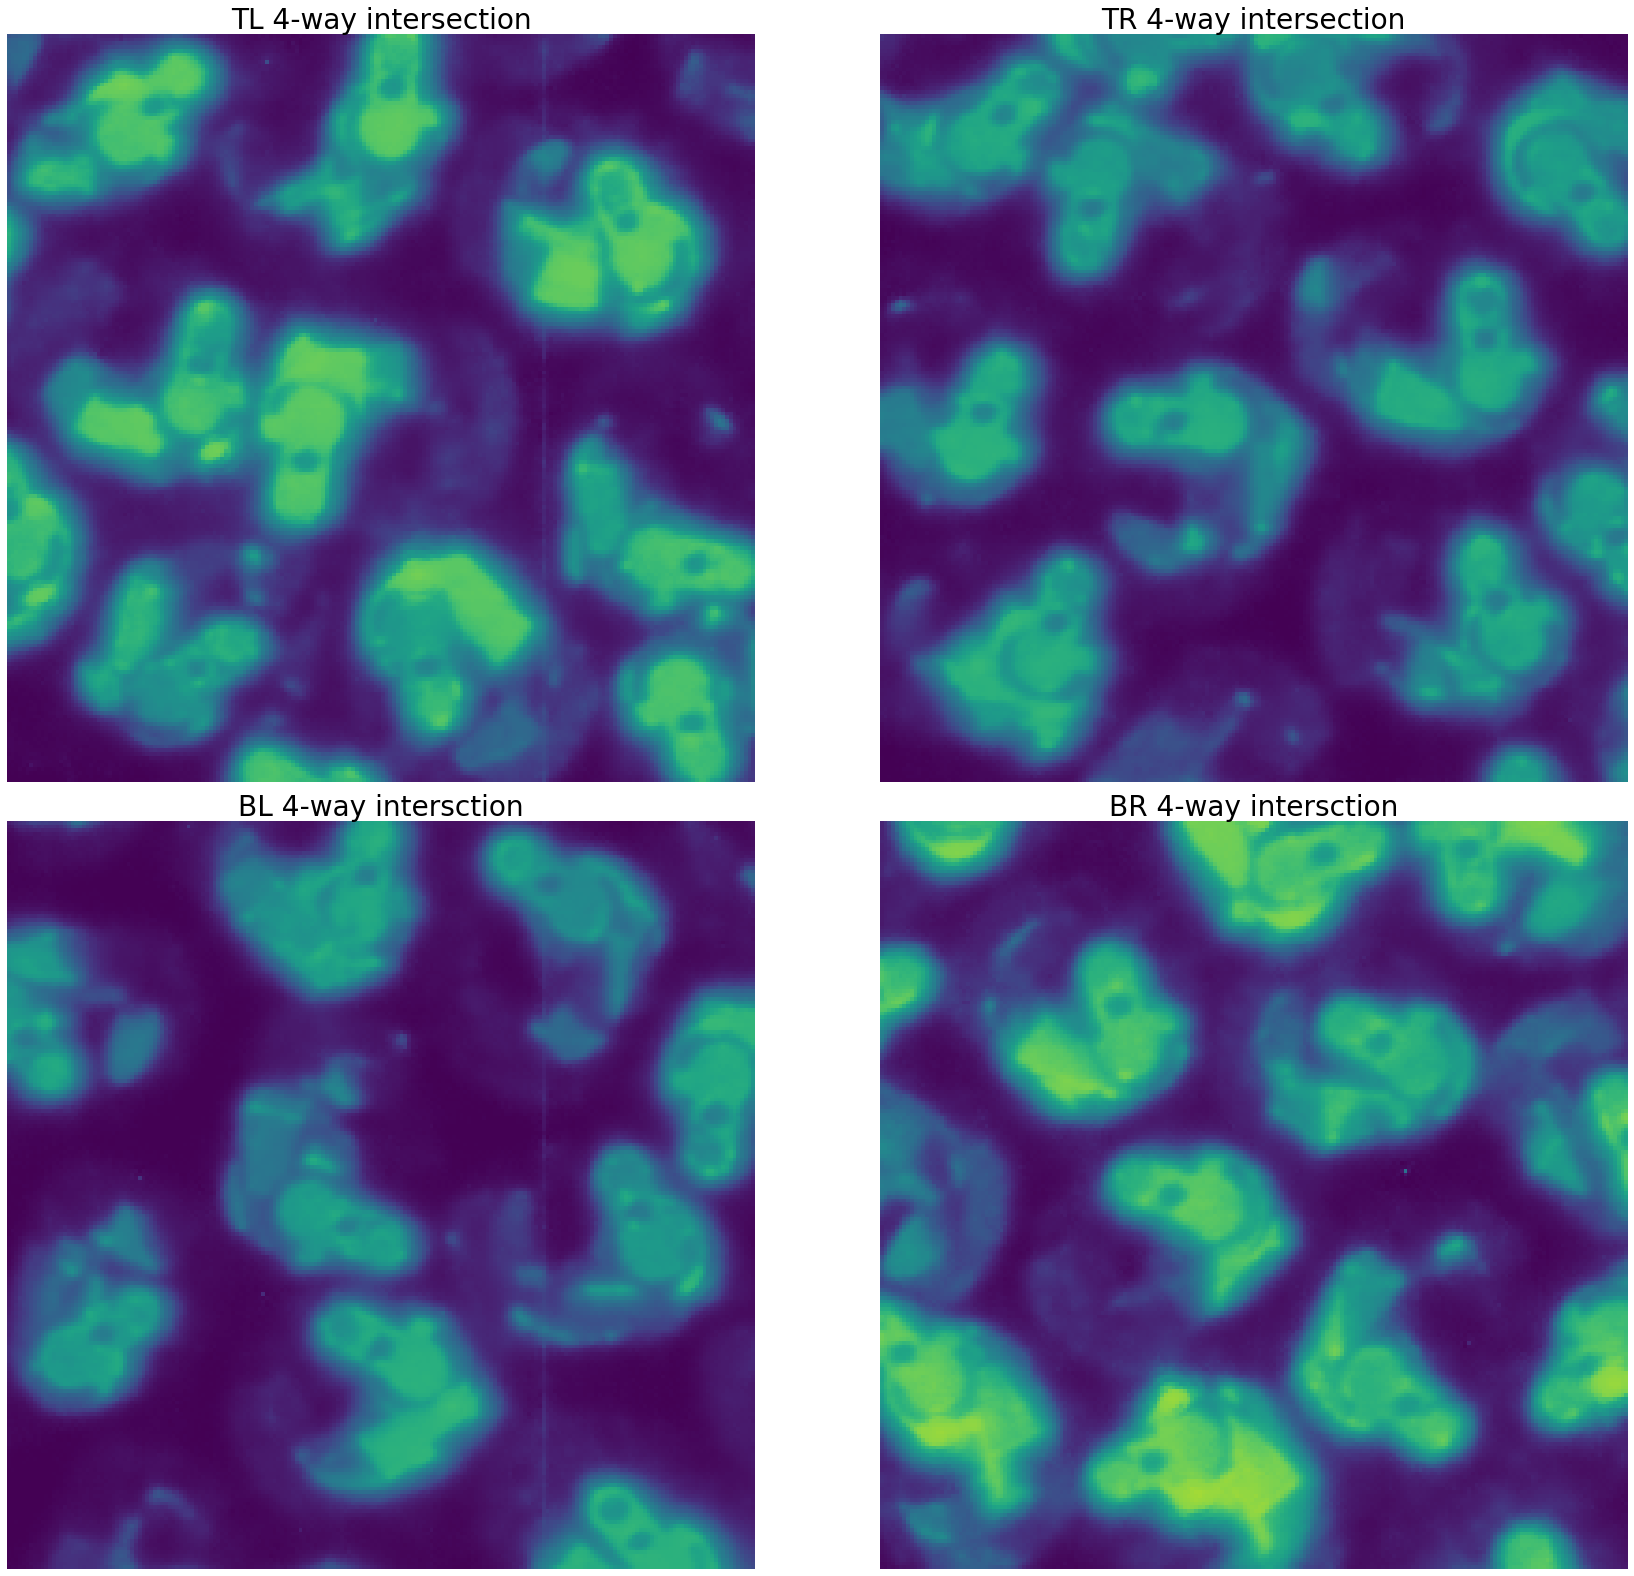

In [25]:
afterburner_int_plot(test_data, denoised, 200, 0, 0)

## Old code that doesn't pad the image, so it has the image artifacts we're seeing in `afterburner`, as well as, `full_img_pass`

The function takes the whole test data. This needs to be fixed to just give it a single 6k by 6k image and run the `afterburner` on this. This will require some tweaking of the current script to be able to run.

**ALSO:** Want to get this working agnostically with the Numpy version of the model.
- This will require making the Numpy model into a script and then further generalizing the `afterburner` function

`afterburner` version that works on PyTorch takes ~14s.

In [3]:
denoised_2k = afterburner(dataset=test_data, model=DnCNN_B,  model_params='2k_model_bs64_e800_ps50_Adam.pth', samp_idx=0)

In [4]:
denoised_2k.shape

(1, 1, 6000, 6000)

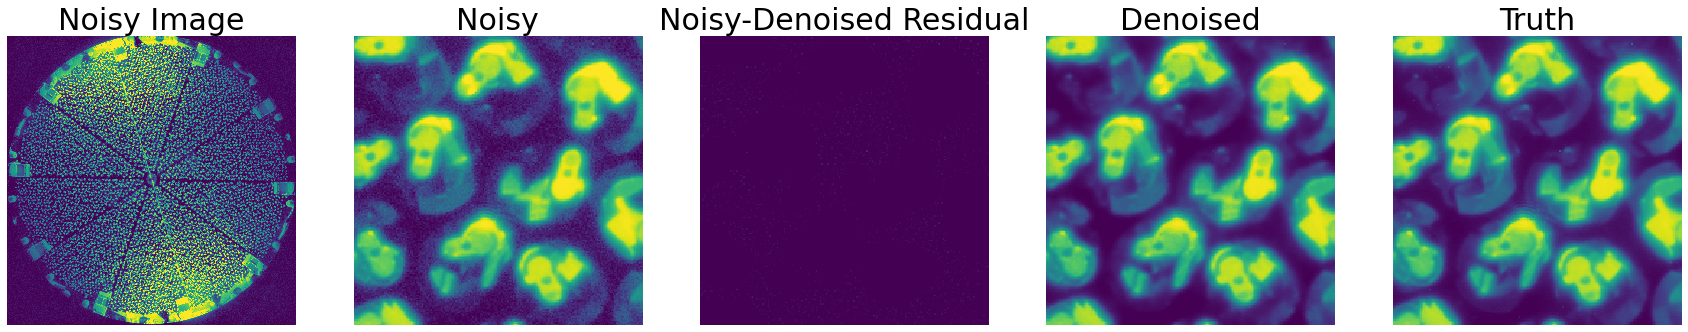

In [5]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][0][start_idx:end_idx, start_idx:end_idx]
    data_6k_truth = raw_data[1][0][0][start_idx:end_idx, start_idx:end_idx]

    full_img_inf = inf_data[0][0][start_idx:end_idx, start_idx:end_idx]
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 5,figsize=(30, 26))
    vmin, vmax = np.percentile(data_6k_raw, (1,99))

    # NOTE: to display the FP in the correct orientation origin='upper',
    # while usually I set it to 'lower'. 
    # Ask David/figure out why this is.
    ax[0].imshow(raw_data[0][0][0], vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=30) 
    ax[2].imshow(np.abs(full_img_inf - data_6k_raw),vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=30)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=30) 
    ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Truth', fontsize=30)
    
plot_comparison(raw_data=test_data,
                inf_data=denoised_2k,
                size=200,
                start_idx=1400,
                end_idx=1600)

# `afterburner` using NumPy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import pickle
import torch

import PT_files.save_load as sl
from DnCNN_NP.layers_np import relu, np_BatchNorm2d, np_Conv2d
from DnCNN_NP.model_np import np_DnCNN

import time 
import pdb

In [7]:
# Loading data & weights dictionary

PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()
# name = '6k_model_wb_e800_lys20_58feat.pth'
name = '2k_model_bs64_e800_ps50_Adam.pth'
# weights = np.load(DATA / name)
weights = torch.load(str(DATA / name))


#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

samp = sample[0][0][1000:3020, 1000:3020]
samp = samp.reshape((1, 1, 2020, 2020))

samp_6k = sample[0]
samp_6k = np.reshape(samp_6k, (1, 1, 6000, 6000))


Shape of test set= (108, 1, 6000, 6000)


In [8]:
im2col_mat = sl.NERSC_load(name='im2col_layer_dict_2k.pkl')
im2col_layer_list = sl.NERSC_load(name='2k_NP_layers_list.pkl')

In [9]:
denoised_np = np_DnCNN(input_data=samp, 
                       weights_dict=weights, 
                       layer_list=im2col_layer_list, 
                       im2col_mat=im2col_mat)

**Work for tomorrow:**

1. Get `grid_window` working for numpy version - **Done**
    - See why there's a UnboundLocalError
    - The `height` variable is definitely called before being used because it's created with the unpacking of the data shape via the `if/elif` statements...or so I thought?
2. Once `grid_window` is working get the rest of the afterburner functions working
    - **Should probably load in the `model_params`, `layer_lists`, and `im2col_mat` before using `grid_window` or any other afterburner functions.**
        - This will save a lot of time due to how large these are and how **often** they will be called.
3. Create master function that allows the user to call the `numpy` or `pytorch` version of the afterburner function
    - NOTE: CLEAN UP THE DOCUMENTATION OF THE `afterburner` function
        - Also GENUINELY consider rewriting the whole function because it is very poorly written and really hard to understand. Maybe adding visuals would be helpful?
        
        
Potentially update the sliding window functions to use the iterators for cleaner implementation. Need to figure out how to implement that and also how to get the indices for the H/W= [start, end], respectively. 

In [15]:
def grid_window(data,
                weights_dict,
                layer_list,
                im2col_mat,
                h_start,
                h_end,
                w_start,
                w_end,
                padding):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Numpy model
        np_DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
    padding: int
        How much to pad the input image to allow for artifact free
        stitching of denoised patchs.
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
      
    full = np.empty((1, 1, 6000, 6000))
    
    # There might be a problem here if we're indexing too many indices if we only have a single image.
    noise_data = np.pad(data, ((0,0), (0,0), (padding, padding), (padding,padding)))
    noise_data = data[:, :, h_start:h_end, w_start:w_end]   

    # Load the model with corresponding weights, layer lists, and im2col matrices
    # and run inference (ie. denoise the image)
    denoised_img = np_DnCNN(input_data=noise_data, 
                     weights_dict=weights_dict,
                     layer_list=layer_list,
                     im2col_mat=im2col_mat)
        
    # Keep the denoised pixels together + the number of times
    # specific pixels had inference ran on them
    full[:, :, h_start:h_end, w_start:w_end] += denoised_img[:, :, 10:-10, 10:-10]        
        
    return full

In [18]:
full = grid_window(data=samp_6k,
                   weights_dict=weights,
                   layer_list=im2col_layer_list,
                   im2col_mat=im2col_mat,
                   h_start=0,
                   h_end=2020,
                   w_start=0,
                   w_end=2020,
                   padding=10)

ValueError: operands could not be broadcast together with shapes (1,1,2020,2020) (1,1,2000,2000) (1,1,2020,2020) 

In [41]:
def np_afterburner(data,
                     model,
                     weights_dict,
                     layer_list,
                     im2col_mat,
                     patch_size=2000,
                     padding=10):
    
    """
    Function that runs a denoising window over ~2kx2k patchs of the
    full 6kx6k FVC image. The reason for doing it in patchs is due to
    memory constraints when running the numpy function over the entire 
    6kx6k image.
    
    Parameters:
    -----------
    data: np.array
        Input FVC image.
    model: Numpy model
        np_DnCNN
    weights_dict: Dict
        Dictionary of the weights for a 2k np_DnCNN model.
    patch_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image. 
        Defaults to 2000.
    padding: int
        How much to pad the FVC image and patch image. Padding it allows
        for slight overlap between denoised patchs. This allows for no
        artifacts to come about, thus having a pure denoised image.
        
    Returns:
    --------
    full: np.array
        Full denoised FVC image.
    """
    
   
    # Reshape the image to be in the correct format to be used in the model.  
    noisy = np.reshape(data, (1, 1, 6000, 6000))
    # Pad the FVC image for overlapping patchs
    # Doing this eliminates artifacts that show up at the edges of the
    # individual patchs.
    noisy = np.pad(noisy, ((0,0), (0, 0), (padding, padding), (padding, padding)))

    # Get how many patchs fit within our FVC image.
    # E.g. patchs_per_dim == 3 if patch_size == 2000
    # We're indexing on the H axis of the img ie. data[0][0] == 6000
    patchs_per_dim = int(len(data[0][0]) / patch_size)
    
    # Create the indices of where one patch ends and the other one begins.
    # Save those together in a list for later use. Expected output will
    # be [0, 2000, 4000, 6000] if using patch_size=2000.
    window_end_idx = []
    for k in range(patchs_per_dim):
        window_end_idx.append(patch_size*(k))
    window_end_idx.append(len(data[0][0])) # appends endpt ie. 6k
    
    # Full image pass
    full = np.zeros((1, 1, 6000, 6000))

    for j in range(len(window_end_idx)-1):
        for i in range(len(window_end_idx)-1):

            # This gets the 2020x2020 patch we want to run denoise.
            # Adding the padding gets the H/W to be 2020 instead of 2000
            noise_data = noisy[:, :, 
                               window_end_idx[i]:window_end_idx[i+1]+(padding*2),
                               window_end_idx[j]:window_end_idx[j+1]+(padding*2)]
            
            # Run the model on this patch of the FVC image
            denoised_patch =  model(input_data=noise_data, 
                                       weights_dict=weights_dict,
                                       layer_list=layer_list,
                                       im2col_mat=im2col_mat)
            
            # Crop the 10x10 border of the denoised_patch, so that when
            # we stitch it together there's no artifacts between neighboring
            # patchs.
            denoised_patch = denoised_patch[:, :, 10:-10, 10:-10]
            
            # Add the denoised patch to the empty array of FVC size
            full[:, :, window_end_idx[i]:window_end_idx[i+1],
                 window_end_idx[j]:window_end_idx[j+1]] += denoised_patch
            
    return full

In [42]:
len(samp_6k)

1

In [43]:
denoised = np_afterburner(data=samp_6k, 
                            model=np_DnCNN,
                            weights_dict=weights, 
                            layer_list=im2col_layer_list,
                            im2col_mat=im2col_mat)

check 1
check 2
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.
check 3
check 4
Run finished.


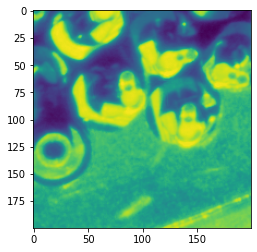

In [45]:
plt.imshow(denoised[0][0][5500:5700, 3900:4100])

`full_img_pass`'s runtime is ~ 16m 40s

In [15]:
# %timeit full, count = full_img_pass(dataset=samp_6k, model=np_DnCNN,weights_dict=weights, layer_list=im2col_layer_list,im2col_mat=im2col_mat)

In [16]:
full, count = full_img_pass(dataset=samp_6k, 
                            model=np_DnCNN,
                            weights_dict=weights, 
                            layer_list=im2col_layer_list,
                            im2col_mat=im2col_mat)

Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.
Run finished.


In [17]:
np.allclose(full[:, :, 1000:3000, 1000:3000], denoised_np)

False

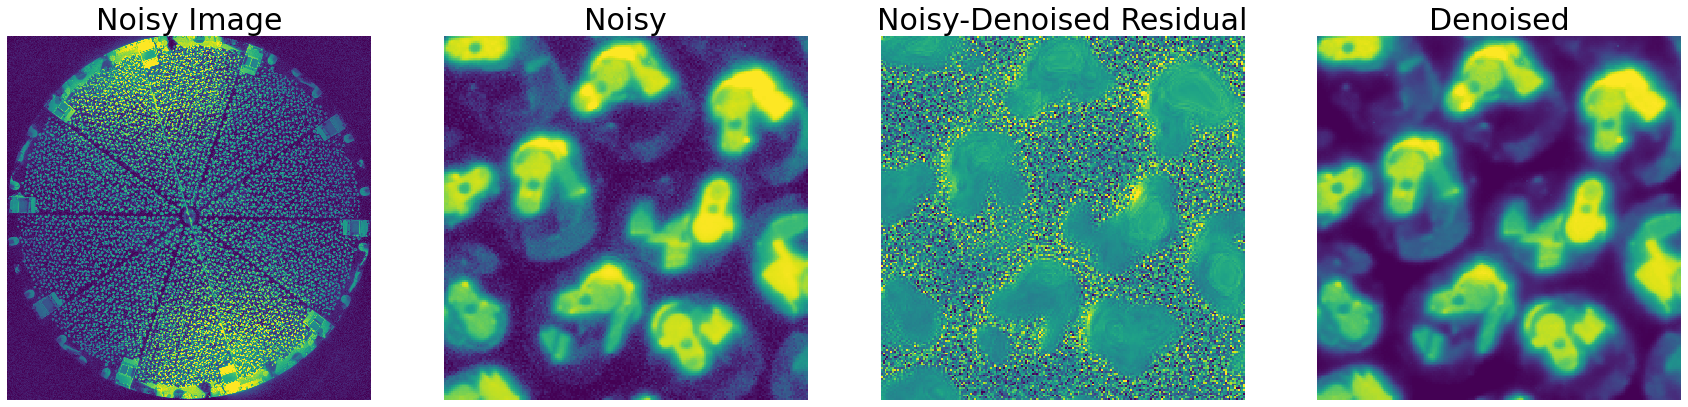

In [47]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k_raw = raw_data[0][0][start_idx:end_idx, start_idx:end_idx]
    # data_6k_truth = raw_data[1][0][start_idx:end_idx, start_idx:end_idx]

    full_img_inf = inf_data[0][0][start_idx:end_idx, start_idx:end_idx]
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 4,figsize=(30, 26))
    # For full focalplane image
    vmin_full, vmax_full = np.percentile(raw_data[0][0], (1, 99)) 
    # For sub-images
    vmin, vmax = np.percentile(data_6k_raw, (1,99))
    # For residuals
    vmin_resid, vmax_resid = np.percentile((full_img_inf - data_6k_raw), (1,99))

    # NOTE: to display the FP in the correct orientation origin='upper',
    # while usually I set it to 'lower'. 
    # Ask David/figure out why this is.
    ax[0].imshow(raw_data[0][0], vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(data_6k_raw, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Noisy',fontsize=30) 
    ax[2].imshow(full_img_inf - data_6k_raw, vmin=vmin_resid, vmax=vmax_resid, origin='upper', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Noisy-Denoised Residual', fontsize=30)
    ax[3].imshow(full_img_inf, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    ax[3].axis('off')
    ax[3].set_title('Denoised',fontsize=30) 
    # ax[4].imshow(data_6k_truth, vmin=vmin, vmax=vmax, origin='upper', interpolation='none')
    # ax[4].axis('off')
    # ax[4].set_title('Truth', fontsize=30)
    
plot_comparison(raw_data=samp_6k,
                inf_data=denoised,
                size=200,
                start_idx=1400,
                end_idx=1600)

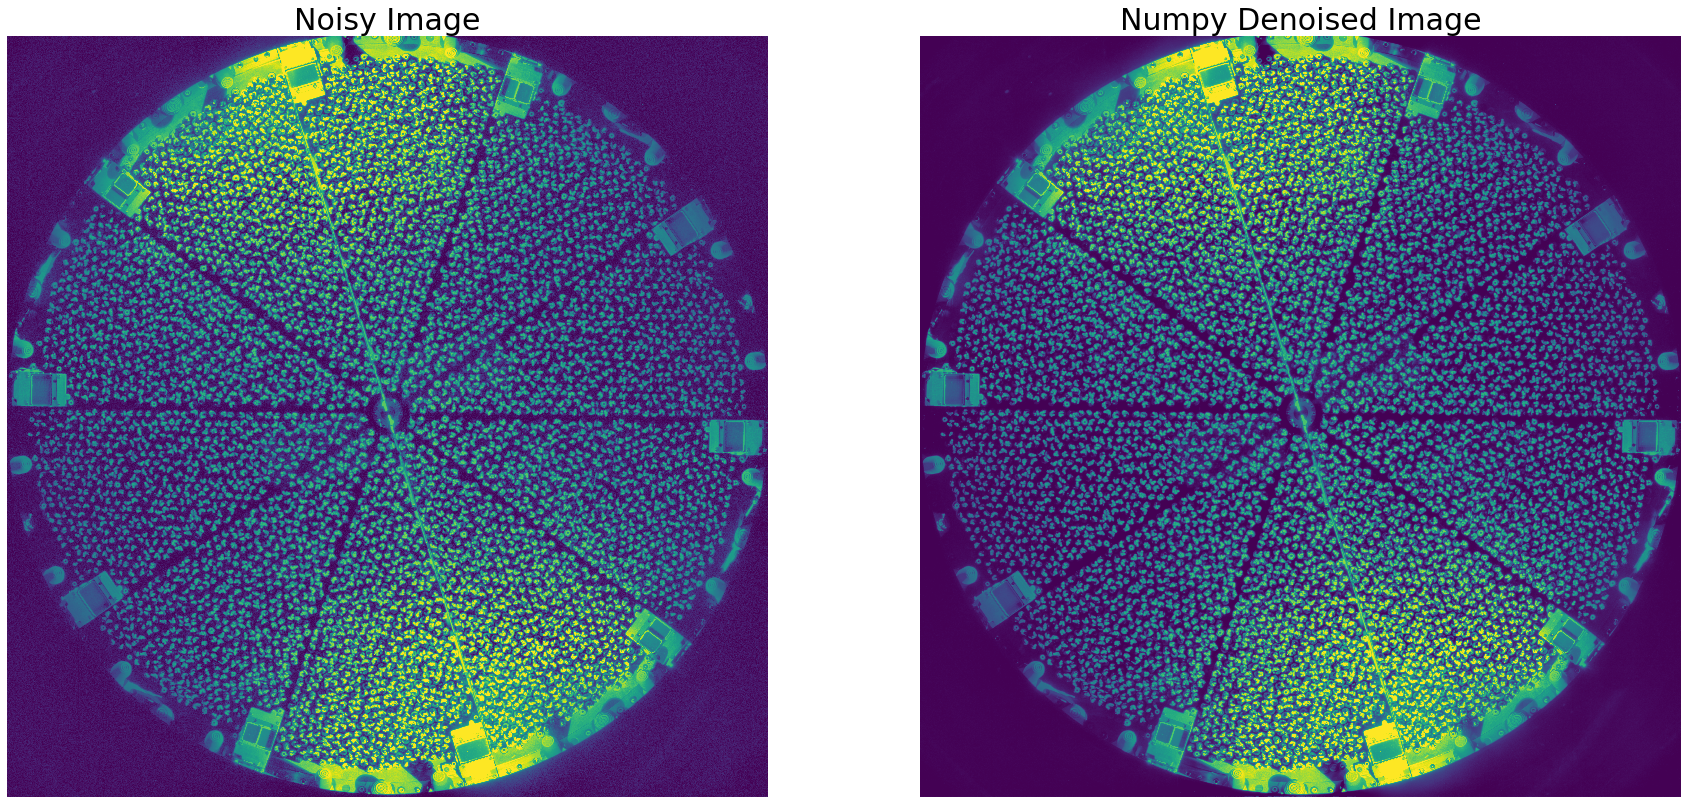

In [48]:
def plot_comparison_full(raw_data, inf_data):
    
    data_6k_raw = raw_data[0][0]
    full_img_inf = inf_data[0][0]
    

    
    
    fig, ax = plt.subplots(1, 2,figsize=(30, 26))
    # For full focalplane image
    vmin_full, vmax_full = np.percentile(raw_data[0][0], (1, 99)) 

    # NOTE: to display the FP in the correct orientation origin='upper',
    ax[0].imshow(raw_data[0][0], vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Image', fontsize=30) 
    ax[1].imshow(full_img_inf, vmin=vmin_full, vmax=vmax_full, origin='upper', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Numpy Denoised Image', fontsize=30)
    
plot_comparison_full(raw_data=samp_6k, inf_data=denoised)